# **LENDING CLUB CASE STUDY** 
## **Group Members :**
1. Karthick Chetti - Group Facilitator
2. Anirudh KVC - Collaborator

## **Contents of Notebook :**
- Objectives
- Understanding Data
- Data Cleaning
- Univariate Analysis
- Segmented Univariate Analysis
- Bivariate Analysis
- Conclusions


## **Objectives :**
1. Understanding the driving factors behind loan default thereby aiming to reduce credit loss 
2. Data Driven inferences to support the driving factors

In [210]:
# Load the libraries
import pandas as pd #To work with dataset
pd.set_option("display.max_columns", 100)
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from matplotlib.ticker import PercentFormatter # for percentage

In [211]:
# Importing data from loan.csv
loan_df=pd.read_csv("loan.csv")

### **Understanding Data** 

In [212]:
loan_df.info(verbose=True,show_counts=True)
init_cols=len(loan_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              39717 non-null  int64  
 1    member_id                       39717 non-null  int64  
 2    loan_amnt                       39717 non-null  int64  
 3    funded_amnt                     39717 non-null  int64  
 4    funded_amnt_inv                 39717 non-null  float64
 5    term                            39717 non-null  object 
 6    int_rate                        39717 non-null  object 
 7    installment                     39717 non-null  float64
 8    grade                           39717 non-null  object 
 9    sub_grade                       39717 non-null  object 
 10   emp_title                       37258 non-null  object 
 11   emp_length                      38642 non-null  object 
 12   home_ownership  

#### We can see that there are some null values in the columns and there are too many columns to analyze, hence measures have to be taken to clean data based on *business objectives* and based on *statistics*

### **Data Cleaning - Filtering out data based on objective, since we cannot get any insights from current customers filtering the data accordingly**

In [213]:
# Filtering data accorgingly
loan_df = loan_df[~(loan_df["loan_status"] == "Current")]

In [214]:
#Removing columns having 50% null values in them as such columns are not useful for analysis
lc_df=loan_df.dropna(axis=1,thresh=int(0.5*len(loan_df)))

In [215]:
#Printing number of columns removed
removed_columns=len(loan_df.columns)-len(lc_df.columns)
print(f"{removed_columns} columns were removed from original dataframe due to high amount of missing values in them")

57 columns were removed from original dataframe due to high amount of missing values in them


### **Data Cleaning - Removing Columns with same values which are redundant for analysis**

In [216]:
#### It is observed that some columns have only one value(mostly 0) throughout the rows, which are not useful for the analysis
dropped_col=[]
for col in lc_df.columns:
    if len(lc_df[col].unique())==1:
        dropped_col.append(col)
print(f"{len(dropped_col)} columns are dropped in the dataframe due to same values repeating throughout the column")
lc_df=lc_df.drop(dropped_col,axis=1)

8 columns are dropped in the dataframe due to same values repeating throughout the column


### **Data Cleaning** : Removing Columns with either 0s or missing values in them

In [217]:
for c in lc_df.columns:
    if len(lc_df[c].unique())==2:
        print(lc_df[c].unique())

[' 36 months' ' 60 months']
['Fully Paid' 'Charged Off']
[ 0. nan]
[ 0. nan]
[ 0. nan]


In [218]:
no_uniq_cols=["collections_12_mths_ex_med","chargeoff_within_12_mths","tax_liens"]
lc_df.drop(no_uniq_cols,axis=1,inplace=True)
print(f"{len(no_uniq_cols)} columns are dropped since they don't have meaningful unique values for analysis")

3 columns are dropped since they don't have meaningful unique values for analysis


In [219]:
#Checking descriptive columns
desc_cols=[]
for columns in lc_df.columns:
    if lc_df[columns].dtypes == "object" and lc_df[columns].nunique()>50 :
        desc_cols.append(columns)
print("These columns have more than 50 unique values \n",desc_cols)
#Cannot conclude dates and columns with % as descriptive columns
#Member id is also unique but since we already have id, dropping member id
descriptive_cols=["member_id","emp_title","url","desc","title","zip_code"]
print("Dropped the descriptive columns :",descriptive_cols)
lc_df.drop(descriptive_cols,axis=1,inplace=True)

These columns have more than 50 unique values 
 ['int_rate', 'emp_title', 'issue_d', 'url', 'desc', 'title', 'zip_code', 'earliest_cr_line', 'revol_util', 'last_pymnt_d', 'last_credit_pull_d']
Dropped the descriptive columns : ['member_id', 'emp_title', 'url', 'desc', 'title', 'zip_code']


In [220]:
exis_cols=len(lc_df.columns)
print(f"As a result of data cleaning, out of {init_cols} columns, {exis_cols} columns exist.\nHowever it is important to select the most relevant columns out of these {exis_cols} for analysis")

As a result of data cleaning, out of 111 columns, 37 columns exist.
However it is important to select the most relevant columns out of these 37 for analysis


### **Selecting most relevant features as per business objective** 
### Additional features/columns will be added to the analysis in the future if it's found relevant

In [221]:
# Key features
# Here id is conidered for aggregation purpose
req_features=["id","loan_amnt","term","int_rate","grade","home_ownership","emp_length","annual_inc","verification_status","purpose","dti","loan_status","earliest_cr_line","addr_state"]
lc_df = lc_df[req_features]

In [222]:
# Having a look at the data
lc_df.head()

,id,loan_amnt,term,int_rate,grade,home_ownership,emp_length,annual_inc,verification_status,purpose,dti,loan_status,earliest_cr_line,addr_state
0,1077501,5000,36 months,10.65%,B,RENT,10+ years,24000.0,Verified,credit_card,27.65,Fully Paid,Jan-85,AZ
1,1077430,2500,60 months,15.27%,C,RENT,< 1 year,30000.0,Source Verified,car,1.00,Charged Off,Apr-99,GA
2,1077175,2400,36 months,15.96%,C,RENT,10+ years,12252.0,Not Verified,small_business,8.72,Fully Paid,Nov-01,IL
3,1076863,10000,36 months,13.49%,C,RENT,10+ years,49200.0,Source Verified,other,20.00,Fully Paid,Feb-96,CA
5,1075269,5000,36 months,7.90%,A,RENT,3 years,36000.0,Source Verified,wedding,11.20,Fully Paid,Nov-04,AZ


In [223]:
# Understanding the data and data types
lc_df.info(verbose=True,show_counts=True)
lc_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   38577 non-null  int64  
 1   loan_amnt            38577 non-null  int64  
 2   term                 38577 non-null  object 
 3   int_rate             38577 non-null  object 
 4   grade                38577 non-null  object 
 5   home_ownership       38577 non-null  object 
 6   emp_length           37544 non-null  object 
 7   annual_inc           38577 non-null  float64
 8   verification_status  38577 non-null  object 
 9   purpose              38577 non-null  object 
 10  dti                  38577 non-null  float64
 11  loan_status          38577 non-null  object 
 12  earliest_cr_line     38577 non-null  object 
 13  addr_state           38577 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 4.4+ MB


,id,loan_amnt,annual_inc,dti
count,3.857700e+04,38577.000000,3.857700e+04,38577.000000
mean,6.763787e+05,11047.025430,6.877797e+04,13.272727
std,2.092639e+05,7348.441646,6.421868e+04,6.673044
min,5.473400e+04,500.000000,4.000000e+03,0.000000
25%,5.120330e+05,5300.000000,4.000000e+04,8.130000
50%,6.564230e+05,9600.000000,5.886800e+04,13.370000
75%,8.291460e+05,15000.000000,8.200000e+04,18.560000
max,1.077501e+06,35000.000000,6.000000e+06,29.990000


### **Missing value imputation**

### There are some columns which have missing values,Therefore understanding the number of missing values in these columns

In [224]:
empty_cols=lc_df.columns[lc_df.isna().any()].tolist()
empty_vals=[round(lc_df[col].isna().sum()*100/len(lc_df[col]),2) for col in empty_cols]
empty_per_dict=dict(zip(empty_cols,empty_vals))
print("The missing values percentage in columns is :\n",empty_per_dict)

The missing values percentage in columns is :
 {'emp_length': 2.68}


#### It is observed that in selected columns for analysis, 'emp_length' column has some missing data

In [225]:
# As the number of missing data is less, missing value imputation can be done
# Checking the values in emp_length column
lc_df["emp_length"].value_counts()

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

In [226]:
# Data imputation since total missing value percentage is less than 5%
#  As the most recurring value is 10+years, adding 10+ years whereever the data is missing
lc_df["emp_length"] = lc_df["emp_length"].fillna(lc_df["emp_length"].value_counts().index[0])

### **Understanding variables and their datatypes**

In [227]:
#Understanding the datatypes in the dataframe
lc_df.info(verbose=True,show_counts=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 14 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   loan_amnt            int64  
 2   term                 object 
 3   int_rate             object 
 4   grade                object 
 5   home_ownership       object 
 6   emp_length           object 
 7   annual_inc           float64
 8   verification_status  object 
 9   purpose              object 
 10  dti                  float64
 11  loan_status          object 
 12  earliest_cr_line     object 
 13  addr_state           object 
dtypes: float64(2), int64(2), object(10)
memory usage: 4.4+ MB


In [228]:
# Removing %  from interest rate and converting to float
lc_df["int_rate"]=lc_df["int_rate"].str.replace("%","").astype(float)

### **Understanding type of variable for analysis**
1. **Numeric Data** : <br>
loan_amt,int_rate,annual_inc,dti

2. **Ordered Categorical Data** : <br>
term,grade,emp_length

3. **Unordered Categorical Data** : <br>
home_ownership,purpose,verification_status,loan_status

*id column can be used as a unique row identifier*

In [229]:
#Declaring type of variables
numeric_data=["loan_amnt","int_rate","annual_inc","dti"]
ordered_cat_data=["term","grade","emp_length"]
unordered_cat_data=["home_ownership","purpose","verification_status","loan_status","addr_state"]

### *Correlation between selected features*
To understand the correlation between the selected features for analysis, to avoid any highly correlated features for analysis

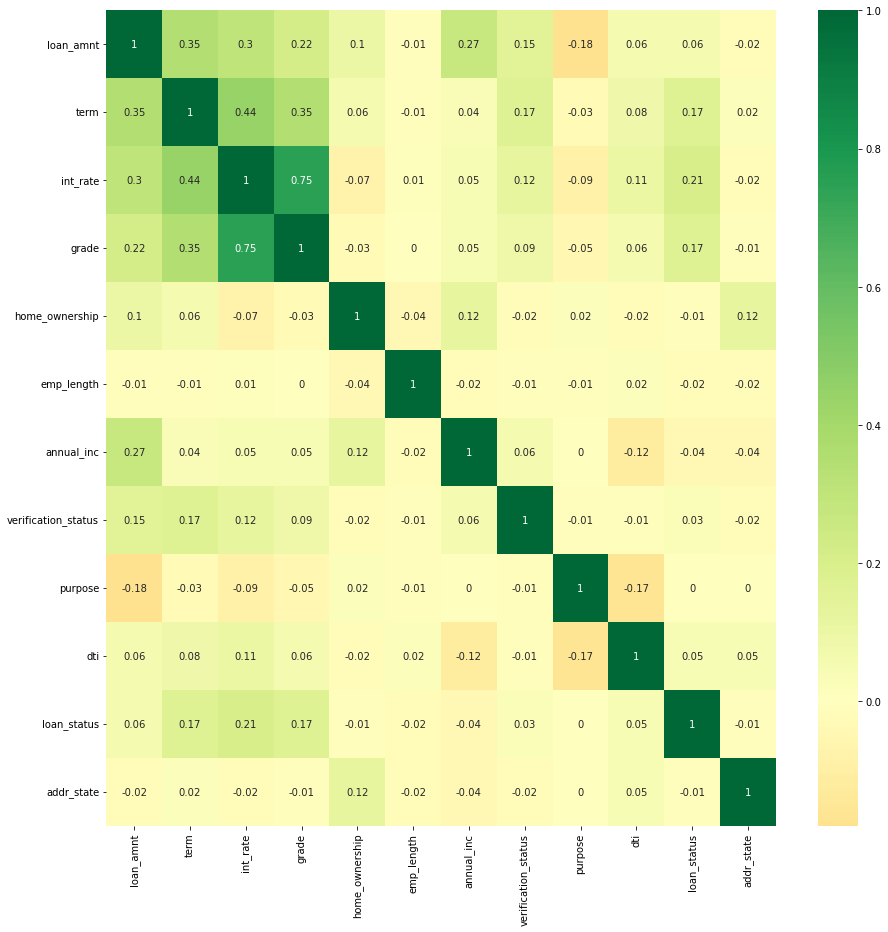

In [230]:
#Categorical Features
lc_df_corr=lc_df
categorical_data=ordered_cat_data+unordered_cat_data
categorical_data
for col in categorical_data:
    col_unique_vals=list(lc_df_corr[col].value_counts().index)
    col_labels=np.arange(1,len(col_unique_vals)+1)
    rep_dict=dict(zip(col_unique_vals,col_labels))
    lc_df_corr=lc_df_corr.replace({col: rep_dict})
lc_corr_matrix=lc_df_corr.corr().round(2)
lc_corr_matrix.drop("id",axis=1,inplace=True)
lc_corr_matrix.drop("id",axis=0,inplace=True)
plt.figure(figsize=(15,15))
sns.heatmap(lc_corr_matrix,center=0, annot=True,cmap="RdYlGn")
plt.show()

As the input features are not highly correlated  among themselves (i.e correlation coefficient <0.9) the selected input features can be taken for the EDA analysis

### Numeric Data Distribution

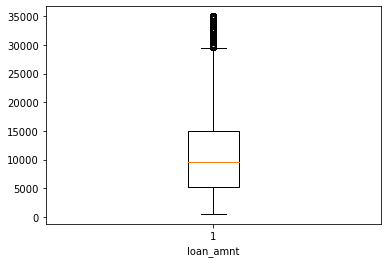

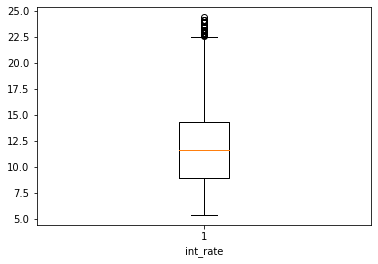

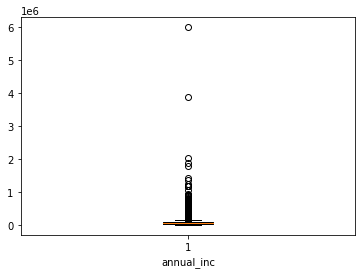

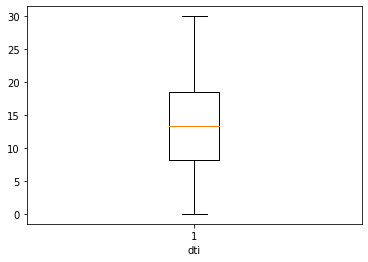

In [231]:
#Checking the distributions for numeric data
#Function to plot box plots taking dataframe and columns as input
def box_plot_col(df,cols):
    for col in cols:
        plt.boxplot(df[col])
        plt.xlabel(col)
        plt.show()
box_plot_col(lc_df,numeric_data)

### Outliers are detected in the box plot for some variables, it is important to remove outliers in the data based on IQR 

In [232]:
#Remove outliers based on IQR (Taking Threshold as 20% because taking 25% standard value is removing many points which might be useful)
def remove_outliers(df,cols,thresh):
    for col in cols:
        ser=df[col]
        Q1 = ser.quantile(thresh)
        Q3 = ser.quantile(1-thresh)
        IQR = Q3 - Q1
        df = df[~(ser > (Q3 + 1.5 * IQR))]
    return df
lc_df=remove_outliers(lc_df,numeric_data,0.20)
removed_data_points=len(loan_df)-len(lc_df)
print(f"{removed_data_points} data points were removed because they were outliers in the numeric data columns")

1650 data points were removed because they were outliers in the numeric data columns


# **Univariate Analysis**

In [233]:
#Looking at dataframe after data cleaning
lc_df.head()

,id,loan_amnt,term,int_rate,grade,home_ownership,emp_length,annual_inc,verification_status,purpose,dti,loan_status,earliest_cr_line,addr_state
0,1077501,5000,36 months,10.65,B,RENT,10+ years,24000.0,Verified,credit_card,27.65,Fully Paid,Jan-85,AZ
1,1077430,2500,60 months,15.27,C,RENT,< 1 year,30000.0,Source Verified,car,1.00,Charged Off,Apr-99,GA
2,1077175,2400,36 months,15.96,C,RENT,10+ years,12252.0,Not Verified,small_business,8.72,Fully Paid,Nov-01,IL
3,1076863,10000,36 months,13.49,C,RENT,10+ years,49200.0,Source Verified,other,20.00,Fully Paid,Feb-96,CA
5,1075269,5000,36 months,7.90,A,RENT,3 years,36000.0,Source Verified,wedding,11.20,Fully Paid,Nov-04,AZ


In [234]:
#Statistical Insights
lc_df[numeric_data].describe()

,loan_amnt,int_rate,annual_inc,dti
count,36927.000000,36927.000000,36927.000000,36927.000000
mean,10476.209142,11.846419,62267.328650,13.380777
std,6597.036775,3.643279,30206.253054,6.660514
min,500.000000,5.420000,4000.000000,0.000000
25%,5000.000000,8.900000,40000.000000,8.270000
50%,9200.000000,11.710000,56100.000000,13.500000
75%,14837.500000,14.270000,78996.000000,18.650000
max,32500.000000,24.400000,169000.000000,29.990000


## Inferences from statistical insights
1) The median of loan amount is 9200</br>
2) The average interest rate is 11.8 %</br>
3) The median of annual income is 56100</br>
4) The average dti ratio is 13.38</br>

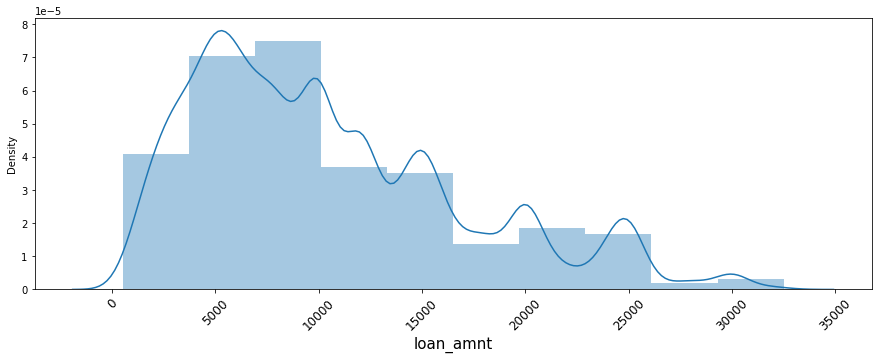

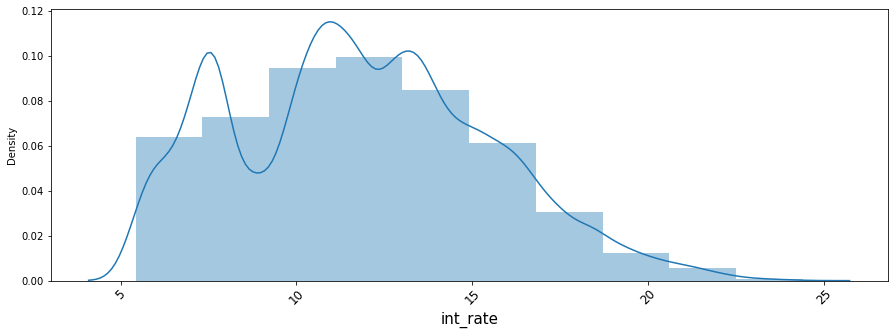

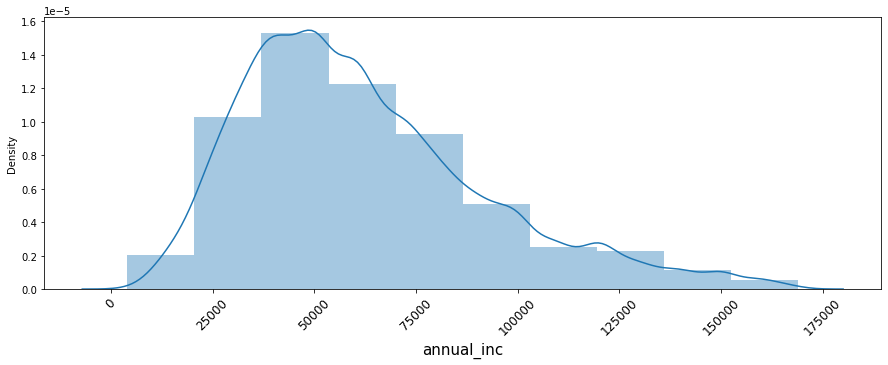

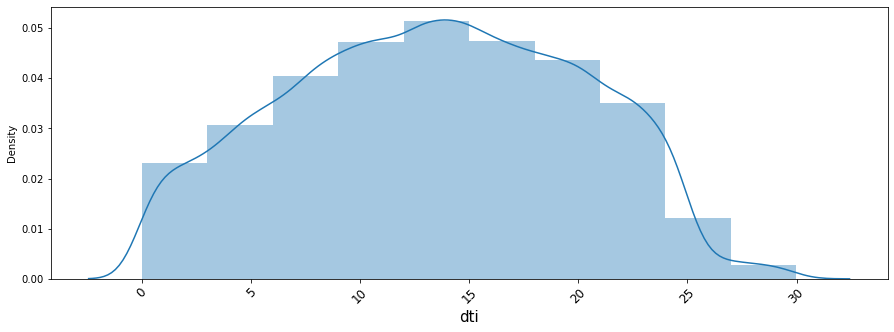

In [235]:
#Plotting distribution plots for numeric variables 
import warnings
warnings.filterwarnings("ignore")
for col in numeric_data:
    plt.figure(figsize=(15,5))
    sns.distplot(lc_df[col],bins=10)
    plt.xticks(fontsize=12,rotation = 45)
    plt.xlabel(col,fontsize=15)
    plt.show()

## Inferences from distribution plots
1) Most of the people prefer loan amount ranging from 4000 to 10000</br>
2) Most of the people prefer taking loans in the range of 10-15 % interest rates, As the interest rate increases beyond 15%, number of customers taking loans reduces significantly</br>
3) Most of the prople annual income if from 25000 to 60000,Annual Income follows a near normal distribution which is right-skewed</br>
4) The dti ratio is almost following normal distrituion with peak near to 14 dti</br>

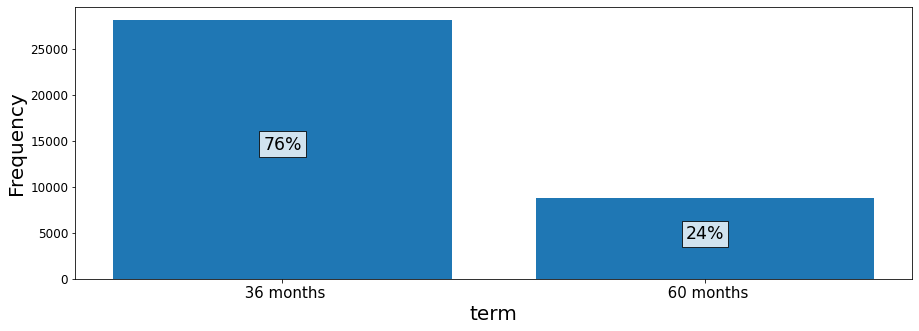

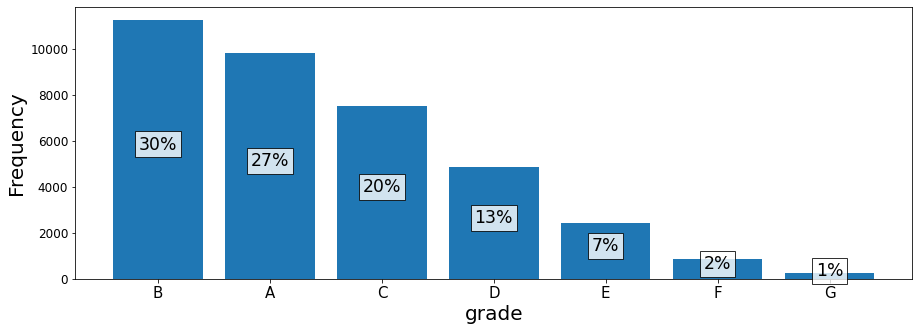

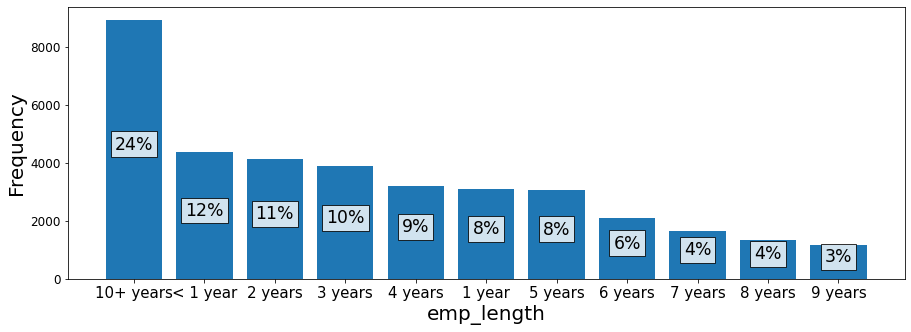

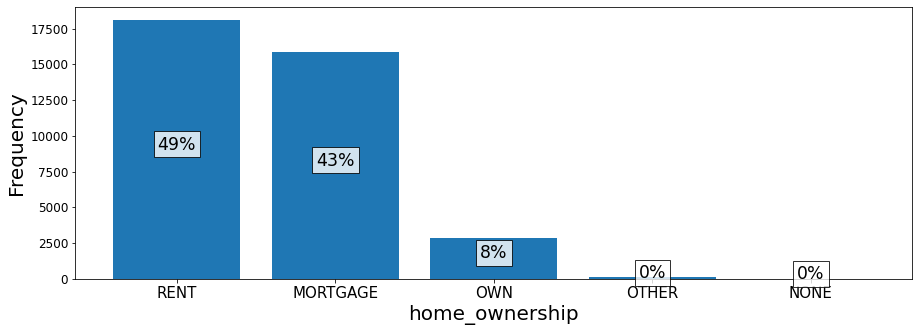

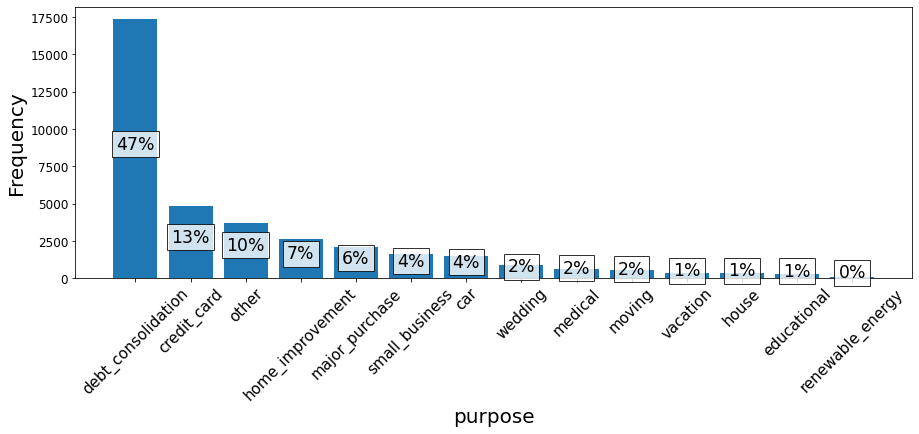

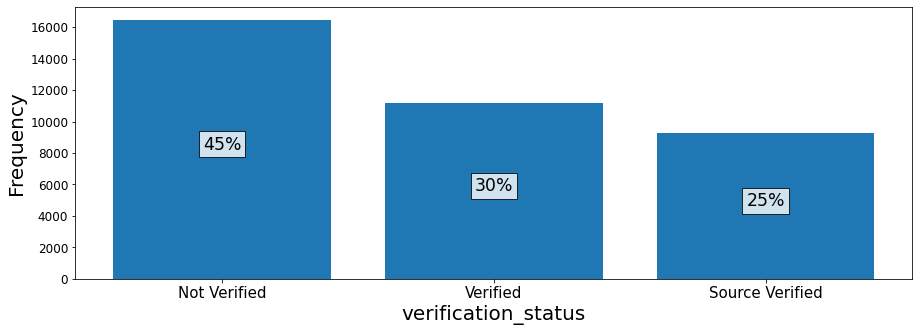

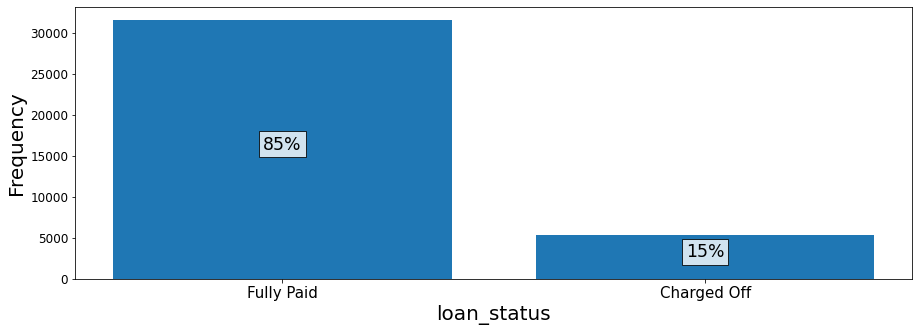

In [236]:
#Plotting bar for ordered categorical variables & unordered categorical variables
cat_data=ordered_cat_data+unordered_cat_data
cat_data.remove("addr_state")
for col in cat_data :
    plt.figure(figsize=(15,5))
    plt.bar(lc_df[col].value_counts().index,lc_df[col].value_counts().values)
    if col=="purpose":
        rot=45
    else:
        rot=0
    plt.xticks(fontsize=15,rotation = rot)
    plt.xlabel(col,fontsize=20)
    plt.ylabel("Frequency",fontsize=20)
    plt.yticks(fontsize=12)
    for i,h in enumerate(lc_df[col].value_counts().values):
        val=int(round(((h/len(lc_df))*100),0))
        plt.text(i,h/2,str(val)+"%",ha="center", bbox = dict(facecolor = 'white', alpha = 0.8),size="xx-large")
    plt.show()

## Inferences from categorical variables
1) About three quarters of the customers prefer 36 months of loan duration</br>
2) About 80% of the customers take loans in grades A,B,C</br>
3) About a quarter of loans are taken by customers having 10+ years of experience</br>
4) Majority of the people who have taken the loan are on rent & mortgage</br>
5) Most of the people take loans for debt consolidation</br>
6) 45% of the loans are given to people whose information is not verified</br>
7) About 85% of the loans are fully paid, charge off percentage is 15%, this leads to credit loss</br>

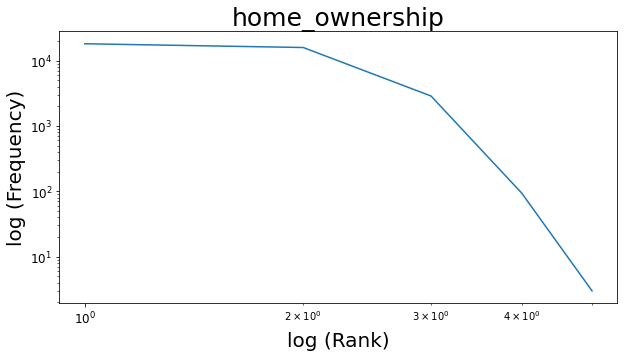

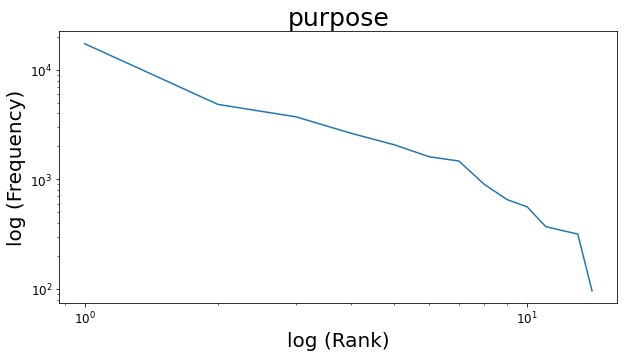

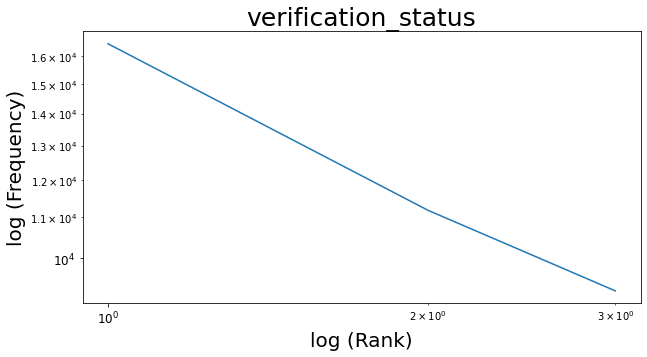

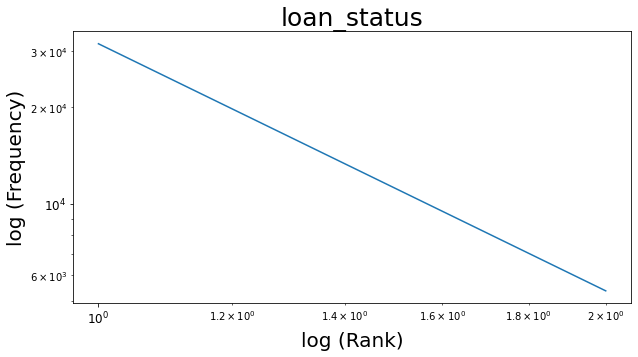

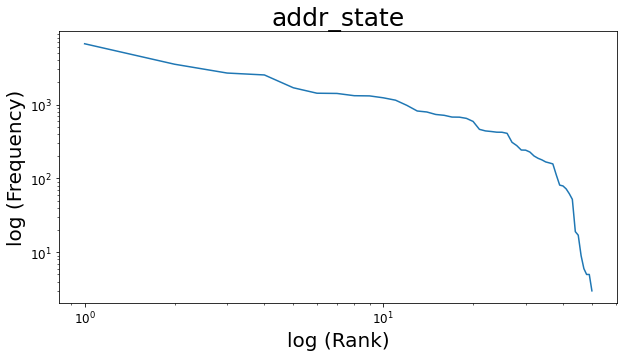

In [237]:
#Unordered categorical variables
for i in unordered_cat_data:
    if i!="zip_code":
        x_data = np.arange(1,len(lc_df[i].value_counts())+1)
        y_data = lc_df[i].value_counts().values
        plt.figure(figsize=(10,5))
        plt.loglog(x_data,y_data)
        plt.xlabel("log (Rank)",fontsize=20)
        plt.ylabel("log (Frequency)",fontsize=20)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(i,fontsize=25)
        plt.show()


### From the rank vs frequency plots it can be inferred that verification status follow power law distribution
We cannot infer anything from loan status as the number of categories are only two

# **Segmented Univariate Analysis**

### Since univariate analysis is not fully indicative of the business objective to find out the driving variables for charged off customers</br>
We are visualizing the insights with respect to **fully paid** and **charged off** customers

In [238]:
#Statistical Insights
fp=lc_df[lc_df.loan_status=="Fully Paid"]
co=lc_df[lc_df.loan_status=="Charged Off"]
print("Fully Paid\n",fp[numeric_data].describe())
print("Charged Off\n",co[numeric_data].describe())

Fully Paid
           loan_amnt      int_rate     annual_inc           dti
count  31563.000000  31563.000000   31563.000000  31563.000000
mean   10334.622026     11.533319   63155.311162     13.263868
std     6495.174602      3.558216   30392.454285      6.665610
min      500.000000      5.420000    4000.000000      0.000000
25%     5000.000000      8.490000   40000.000000      8.120000
50%     9000.000000     11.480000   57700.000000     13.340000
75%    14400.000000     13.980000   80000.000000     18.520000
max    32500.000000     24.110000  169000.000000     29.990000
Charged Off
           loan_amnt     int_rate     annual_inc          dti
count   5364.000000  5364.000000    5364.000000  5364.000000
mean   11309.340045    13.688768   57042.236924    14.068697
std     7110.922433     3.592941   28534.807584     6.589181
min      900.000000     5.420000    4080.000000     0.000000
25%     5400.000000    11.140000   36000.000000     9.137500
50%    10000.000000    13.490000   51202.0

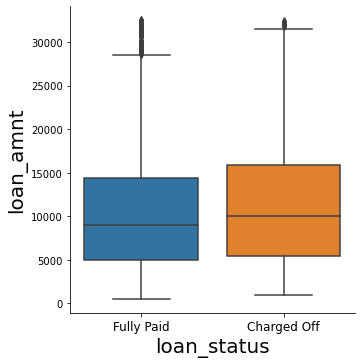

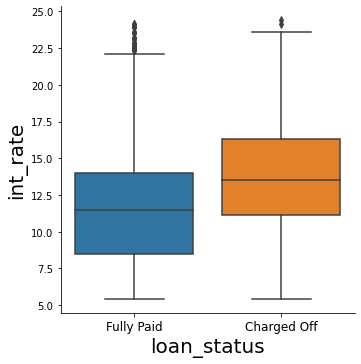

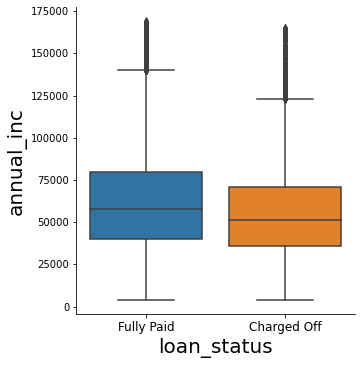

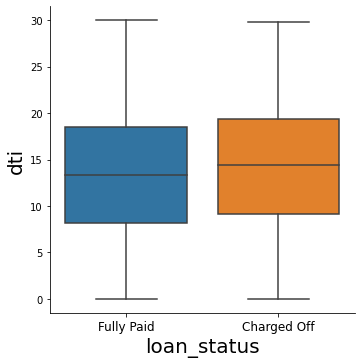

In [239]:
#Bar plots for numeric variables
for col in numeric_data:
    sns.catplot(y=col,x="loan_status",kind="box", data=lc_df)
    plt.xticks(fontsize=12,rotation=0)
    plt.xticks(fontsize=12)
    plt.xlabel("loan_status",size = 20)
    plt.ylabel(col,size=20)
    #plt.legend(fontsize=14)
    plt.show()

## Inferences from segmented univariate analysis
1) wrt loan amount - charged off customers tend to take slightly higher loam amounts which is evident from the median (10000 vs 9000)</br>
2) wrt int_rate - charged off customers tend to take loans at higher interest rates which is evident from the median (13.49 vs 11.48)</br>
3) wrt annual income - charged off cutomers have less annual income compared to fully paid customers (51200 vs 57700)</br>
4) wrt dti - The debt to income ratio of charged off customers is more compared to fully paid customers (14.35 vs 13.34)</br>

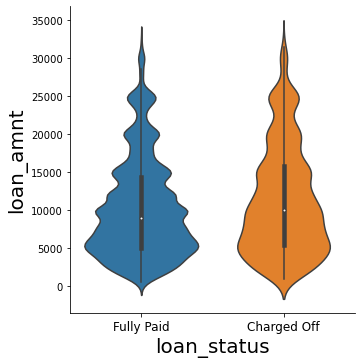

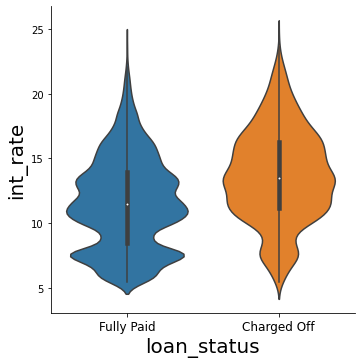

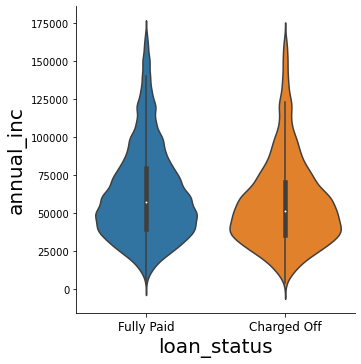

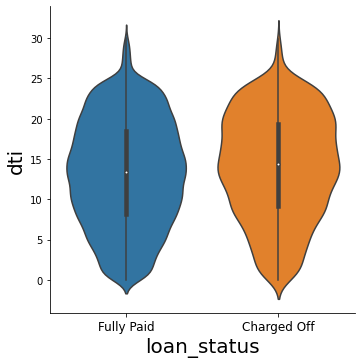

In [240]:
#Violin plots for numeric variables
for col in numeric_data:
    sns.catplot(y=col,x="loan_status",kind="violin", data=lc_df)
    plt.xticks(fontsize=12,rotation=0)
    plt.xticks(fontsize=12)
    plt.xlabel("loan_status",size = 20)
    plt.ylabel(col,size=20)
    #plt.legend(fontsize=14)
    plt.show()

## Inferences 
1) It can be inferred that in the case of fully paid customers that they dont prefer intertest rates from 9 to 10 % where in the charged off customers are preferring int_rates > 10 </br>
2) In case of fully paid customers there are not many taking the loans at int_rate> 14% whereas in the case of charged off customers the pdf of int_rate  down after 16% </br>
3) Fully paid loan amounts are majorly rounded in multiples of 5000(ex. 15k,20k)</br>
3) Not much change in distribution is observed for other features </br>

### Calculation for Segmented Univariate Analysis 
The plots have been made considering the percentages of total fully-paid or charged off to understand the difference between them as using frequency is not a good metric as the data is biased towards fully paid customers (which is expected for a lending company)

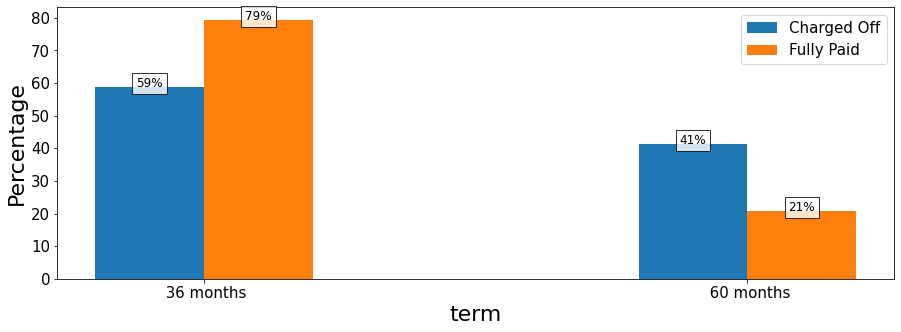

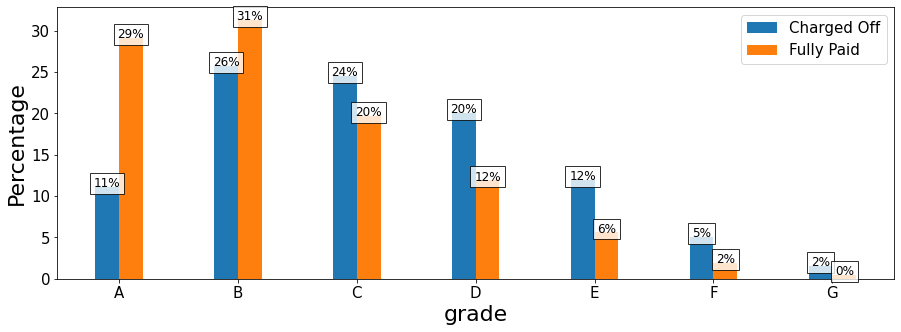

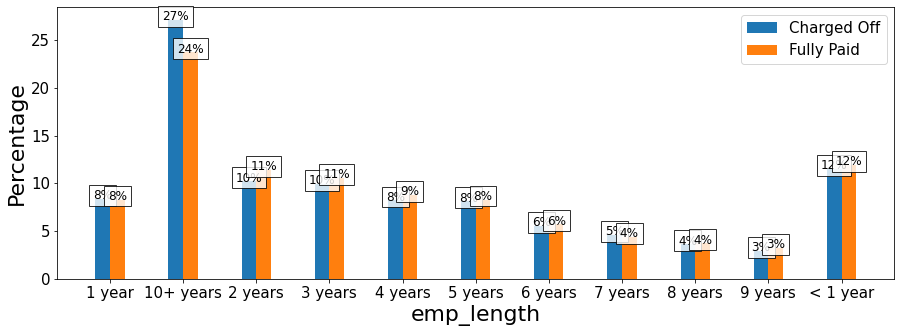

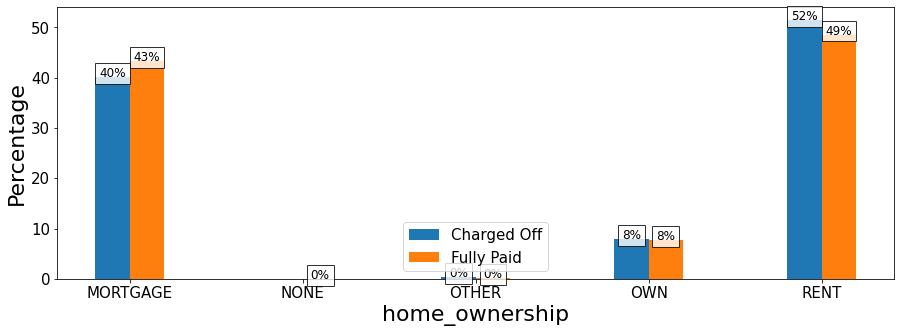

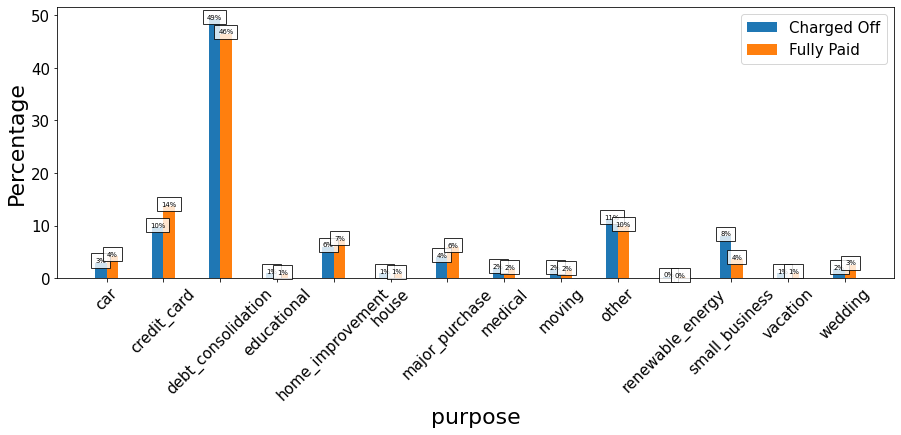

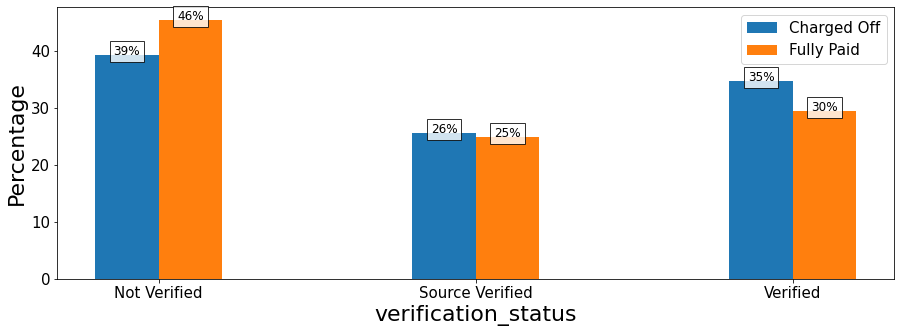

In [241]:
#Histogram for categorical Variables
def plot_bar_cat(df,index_name,column_name,width,x_lbl_rotation):
    pivot=pd.pivot_table(lc_df,values="id",index=index_name,columns=column_name,aggfunc=lambda x: len(x.unique()))
    pivot=round(pivot*100/pivot.sum(axis=0),1)
    plt.figure(figsize=(15,5))
    x_label = pivot.index
    x_data = np.arange(len(x_label)) # create values from 0 to len(x_label) - 1
    chart=[]
#     dec=1
    for j,i in enumerate(pivot.columns):
        chart.append(plt.bar(x_data + j*(width), pivot[i],width=width,align="edge"))
        for l,k in zip(x_data + j*(width) + width/2,pivot[i]):
            try:
                val=str(int(round(k,0)))+"%"
            except:
                val=""
#             k=k/dec
            if index_name=="purpose":
                size="x-small"
                x_lbl_rotation=45
            else:
                size="large"
            plt.text(l,k,val,ha="center", bbox = dict(facecolor = 'white', alpha = 0.8),size=size)
#         dec+=1
    plt.xlabel(index_name,fontsize=22)
    plt.ylabel("Percentage",fontsize=22)
    x_label_pos = x_data + (len(pivot.columns)*width)/2
    plt.xticks(x_label_pos ,x_label,fontsize=15,rotation = x_lbl_rotation)
    plt.yticks(fontsize=15)
    plt.legend(chart,pivot.columns,fontsize=15)
    plt.show()

for col in cat_data:
    if col not in ["loan_status","addr_state"]:
        plot_bar_cat(lc_df,col,"loan_status",0.2,0)


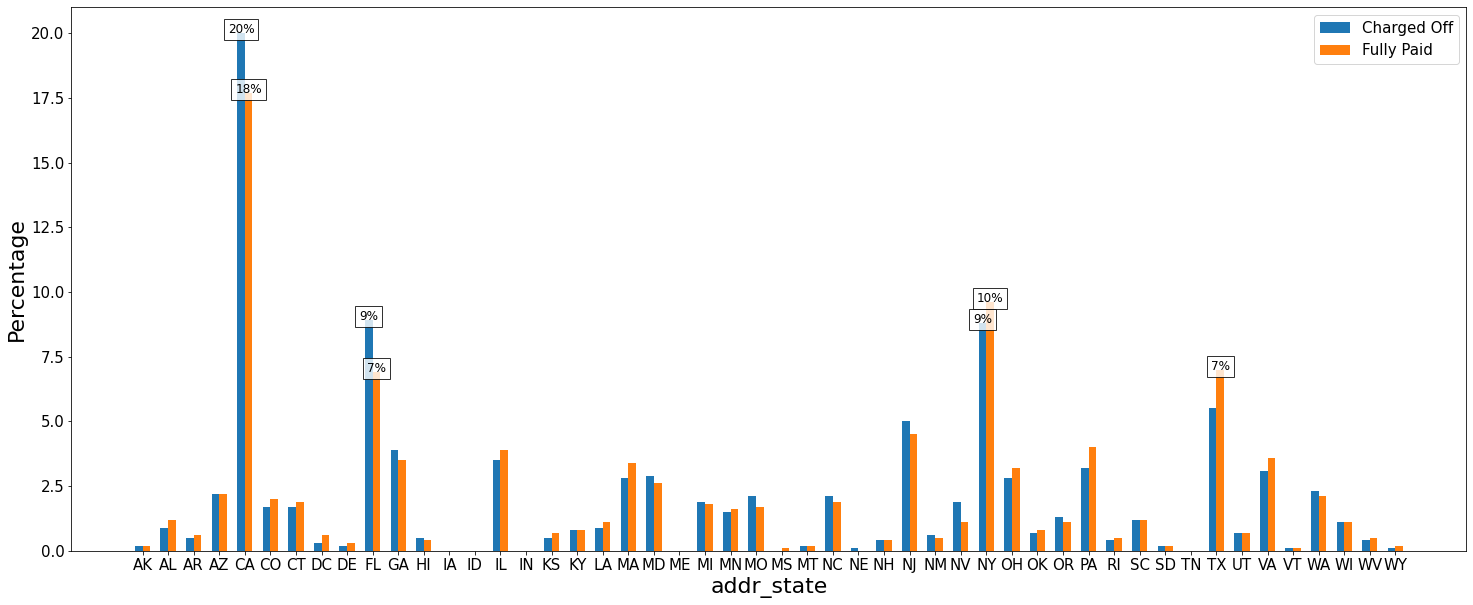

In [242]:
#Function to plot variables with more unique values
def plot_bar_cat_more_features(df,index_name,column_name,width,x_lbl_rotation):
    pivot=pd.pivot_table(lc_df,values="id",index=index_name,columns=column_name,aggfunc=lambda x: len(x.unique()))
    pivot=round(pivot*100/pivot.sum(axis=0),1)
    plt.figure(figsize=(25,10))
    x_label = pivot.index
    x_data = np.arange(len(x_label)) # create values from 0 to len(x_label) - 1
    chart=[]
    for j,i in enumerate(pivot.columns):
        chart.append(plt.bar(x_data + j*(width), pivot[i],width=width,align="edge"))
        for l,k in zip(x_data + j*(width) + width/2,pivot[i]):
            try:
                if int(round(k,0))>=7:
                    val=str(int(round(k,0)))+"%"
                else:
                    val=""
            except:
                val=""
            plt.text(l,k,val,ha="center", bbox = dict(facecolor = 'white', alpha = 0.8),size="large")
    plt.xlabel(index_name,fontsize=22)
    plt.ylabel("Percentage",fontsize=22)
    x_label_pos = x_data + (len(pivot.columns)*width)/2
    plt.xticks(x_label_pos ,x_label,fontsize=15,rotation = x_lbl_rotation)
    plt.yticks(fontsize=15)
    plt.legend(chart,pivot.columns,fontsize=15)
    plt.show()

plot_bar_cat_more_features(lc_df,"addr_state","loan_status",0.3,0)


## Inferences from segmented univariate analysis of categorical variables
1) Charged off customers are significantly higher than fully paid for 60 months term, making 5 years loan tenure a risky option</br>
2) A,B grades have fully paid % > charged off % where as the trend is changed from grade C</br>
3) Customers having 10+ years of experience have high % of charged off customers compared to full paid</br>
4) Customers taking loans for debt consolidation and small business have high percentage of charged off customers compared to fully paid</br>
5) The % of charged off customers are significantly high for verified applications compared to fully paid</br>
6) Customers who have a rented house are risky because they data shows that this category has more charged off than fully paid customers</br>
7) It is observed customers from the states California and Florida charge off more than fully paying the loan 

### **Derived Metrics and Binning**

In [243]:
# Change bin_dict variable for binning numerical variables
bin_dict = {"loan_amnt":np.linspace(0,40000,5),"int_rate":np.linspace(0,25,6),"annual_inc":np.arange(0,195000,25000),"dti":np.linspace(0,30,num=7)}


In [244]:
#Derived Metric 1 : Employee length bins
#Employee length can be binned based on distribution into lesser categories (<1 yr,1-3yr,4-6yr,7-9yr,>10yr)
def bin_emp_len(x):
    if x in ["< 1 year"]:
        return "<1 year"
    elif x in ["1 year","2 years","3 years"]:
        return "1-3 years"
    elif x in ["4 years","5 years","6 years"]:
        return "4-6 years"
    elif x in ["7 years","8 years","9 years"]:
        return "7-9 years"
    elif x in ["10+ years"]:
        return ">10 years"
lc_df['bin_emp_length']=lc_df['emp_length'].apply(bin_emp_len)
#Adding binned column to ordered categorical data
ordered_cat_data.remove("emp_length")
ordered_cat_data.append("bin_emp_length")


In [245]:
#Function to generate labels for binning
def label_generator(x):
    lab = []
    for i in range(0,len(x)-1):
        lab.append(str(x[i]) + " to " + str(x[i+1]))
    return lab

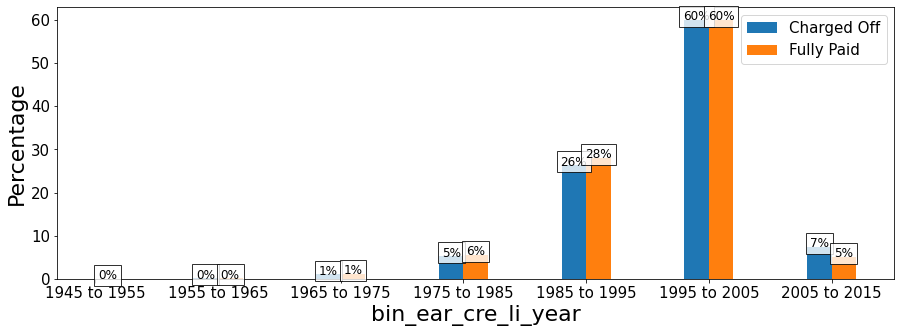

In [246]:
# Derived Metric 2 : Extract year from earliest_cr_line
#lc_df['last_credit_line_year'] = pd.to_datetime(lc_df["earliest_cr_line"],format="%b-%y").dt.year
def year(x):
    y_int=int(x.split("-")[1])
    if y_int>=0 and y_int<=11:
        y_int = y_int + 2000
    else:
        y_int = y_int + 1900
    return y_int
lc_df['ear_cre_li_year'] = lc_df["earliest_cr_line"].apply(year)
#Binning the years
lc_df['ear_cre_li_year'].describe()
range_values_year=np.arange(1945,2025,10)
lc_df["bin_ear_cre_li_year"] = pd.cut(lc_df["ear_cre_li_year"],bins=range_values_year,labels=label_generator(range_values_year),include_lowest=True)
#Updating ordered categorical data with binned column
ordered_cat_data.append("bin_ear_cre_li_year")
plot_bar_cat(lc_df,"bin_ear_cre_li_year","loan_status",0.2,0)

### Inference -
People who have opened credit lines from 1995-2000 have taken about 60% loans,
however new customers(earliest credit line 2005-2015) have charged off more than fully paid the loan, they might be risky


In [247]:
# Binning numerical features
binned_cols = []
for feat,b in bin_dict.items():
    col = "bin_" + feat 
    binned_cols.append(col)
    lc_df[col] = pd.cut(lc_df[feat],bins=b,labels=label_generator(b),include_lowest=True)
# Aggregating binned columns
binned_cols.append("bin_emp_length")
print(binned_cols)

['bin_loan_amnt', 'bin_int_rate', 'bin_annual_inc', 'bin_dti', 'bin_emp_length']


['bin_loan_amnt', 'bin_int_rate', 'bin_annual_inc', 'bin_dti', 'bin_emp_length']


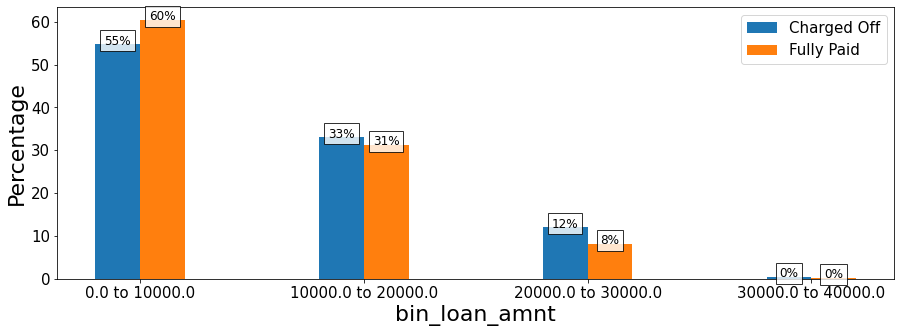

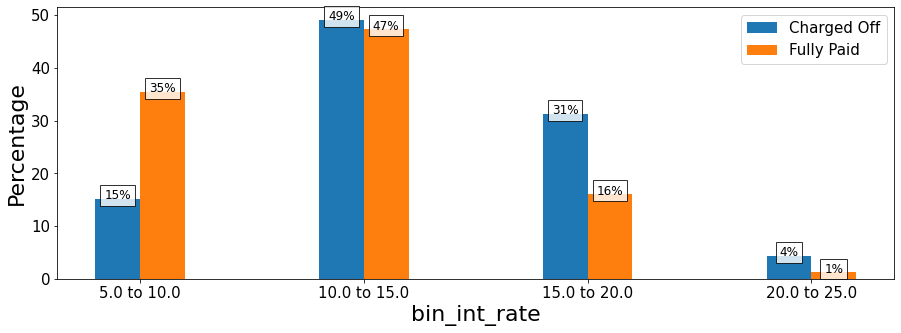

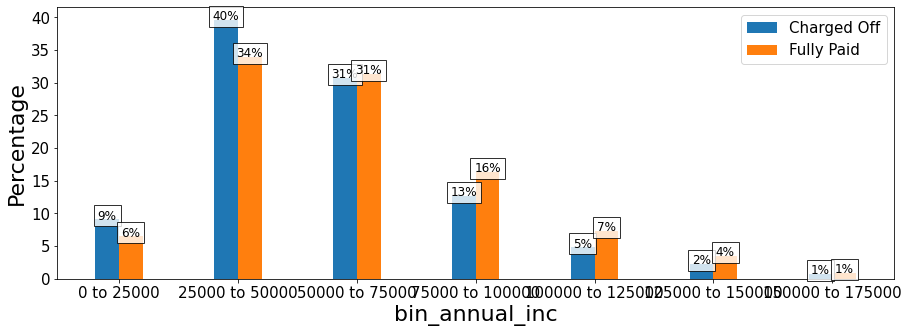

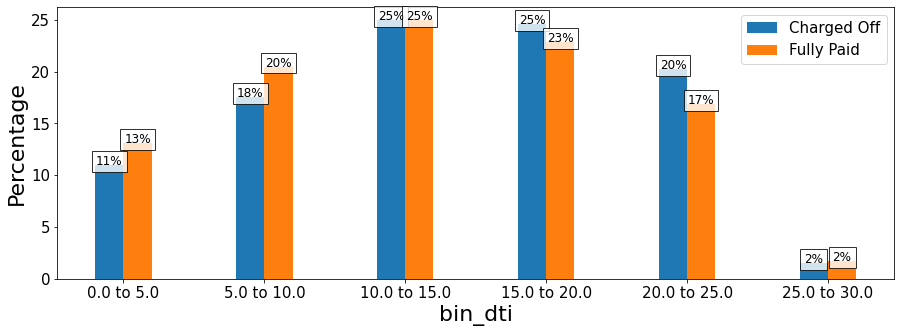

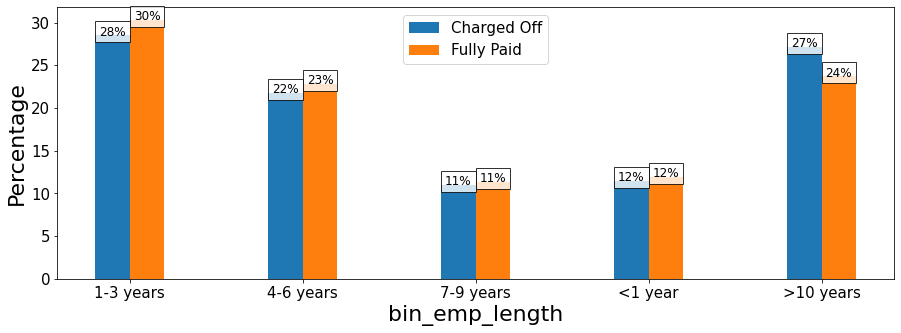

In [248]:
#Visualizing Binned columns
print(binned_cols)
for col in binned_cols:
    plot_bar_cat(lc_df,col,"loan_status",0.2,0)

## Inferences
1) For loan amounts> 10000, the percentage of charged off customers is more than that of fully paid</br>
2) For interest rates > 10% the percentage of charged off customers is more than that of fully paid</br>
3) For annual income < 50000, the % of charged off customers are more than fully paid</br>
4) For dti> 15, the percentage of charged off customers are more than fully paid</br>
5) For emp_length > 10 years the percentage of charged off customers is significantly more than fully paid</br>

# Bivariate Analysis

In [249]:
# Function for plotting bar chart for categorical variables and numerical variables using mean as aggregation function
def plot_bar_cat_num(df,index_name,avg_col_name,width,x_lbl_rotation,flag):
    pivot=pd.pivot_table(df,values=avg_col_name,index=index_name,columns="loan_status")
    plt.figure(figsize=(15,5))
    x_label = pivot.index
    x_data = np.arange(len(x_label)) # create values from 0 to len(x_label) - 1
    chart=[]
    for j,i in enumerate(pivot.columns):
        chart.append(plt.bar(x_data + j*(width), pivot[i],width=width,align="edge"))
        for l,k in zip(x_data + j*(width) + width/2,pivot[i]):
            try:
                if flag=="k":
                    val=str(int(round(k,-3)/1000))+"k"
                else:
                    val=int(k)
            except:
                val=""
            plt.text(l,k,val,ha="center", bbox = dict(facecolor = 'white', alpha = 0.8))
    plt.xlabel(index_name,fontsize=22)
    plt.ylabel("Avg of " + avg_col_name,fontsize=22)
    x_label_pos = x_data + (len(pivot.columns)*width)/2
    plt.xticks(x_label_pos ,x_label,fontsize=15,rotation = x_lbl_rotation)
    plt.yticks(fontsize=15)
    plt.legend(chart,pivot.columns,fontsize=15)
    plt.show()


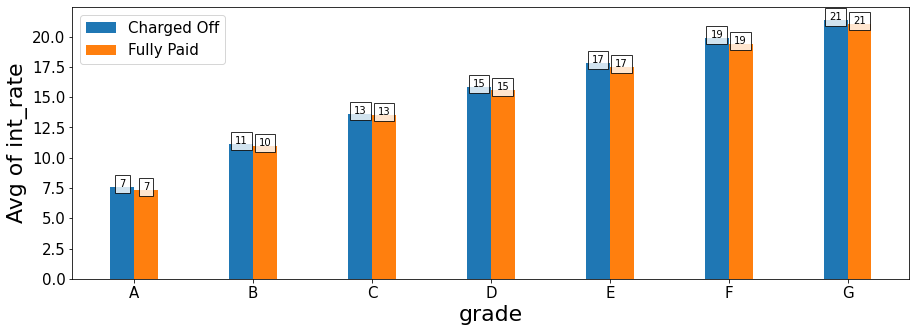

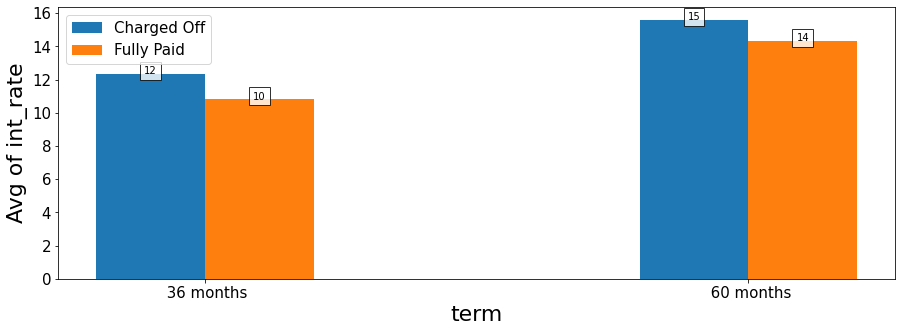

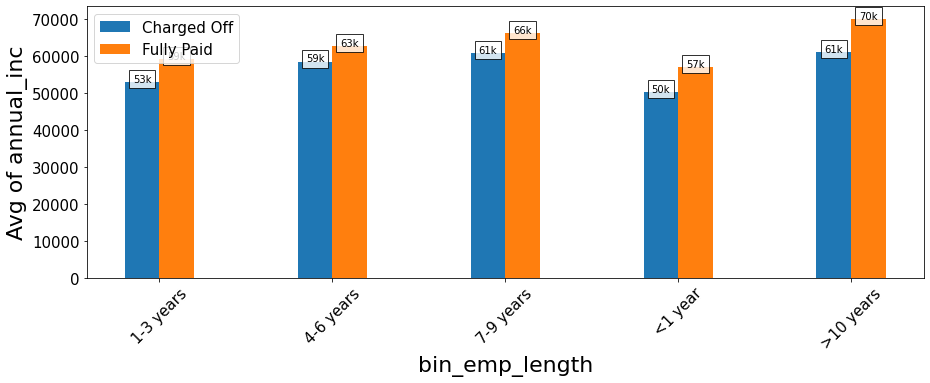

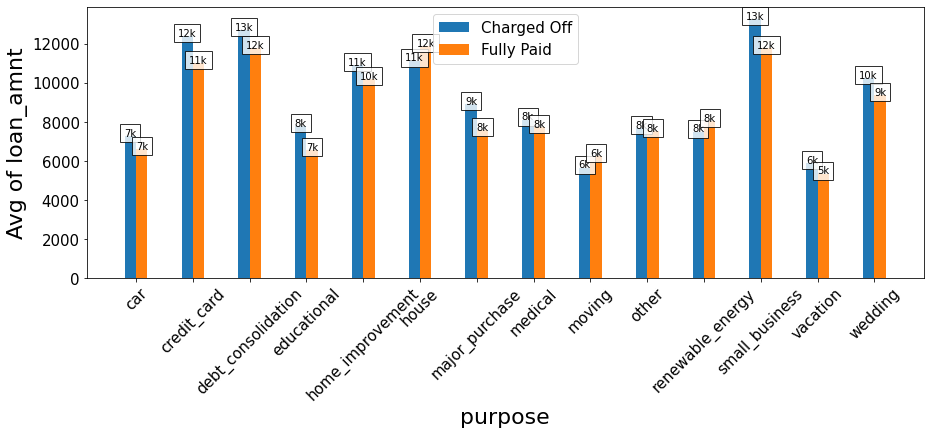

In [250]:
#Plotting relevant graphs
plot_bar_cat_num(lc_df,"grade","int_rate",0.2,0,"n")
plot_bar_cat_num(lc_df,"term","int_rate",0.2,0,"n")
plot_bar_cat_num(lc_df,"bin_emp_length","annual_inc",0.2,45,"k")
plot_bar_cat_num(lc_df,"purpose","loan_amnt",0.2,45,"k")

# Inferences
1) The average interest rate for 60 months is more than that of 36 months for both fully paid and charged off customers being highest for charged off customers @ 60 months</br>
2) Higher interest rates with long tenure could be a reason for charge off</br>
3) From grade A to G the interest rate increases - not much difference was found between fully paid and charged off customers</br>
4) It can be inferred for employees having more than 10 years experience, the average annual income of the fully paid customers is 70,000 where the average annual income of charged customers is 60,000</br>
5) LC can be more careful in examining the experienced employees having annual income < 70,000
6) Irrespective of purpose the avg loan amnt is higher for charged off customers</br>
7) The avg loan amnt is higher for both small business,debt consolidation and credit card - LC should be more cautious in offering loans for these purpose</br>



In [251]:
### Bivariate Analysis
#Since we are interested in analyzing the important factors for defaulters, 
#We are focussing our analysis only on charged off customers
lc_df_co=lc_df[lc_df.loan_status=="Charged Off"]
lc_df_fp=lc_df[lc_df.loan_status=="Fully Paid"]

In [252]:
#Function to plot bivariate graphs for categorical variables
def plot_bar_cat_bi(df,index_name,column_name,x_lbl_rotation,is_stacked):
    ind_len=len(df[index_name].value_counts())
    col_len=len(df[column_name].value_counts())
    #Plotting more categories on x axis
    if ind_len>=col_len:
        index_pivot=index_name
        col_pivot=column_name
    else:
        index_pivot=column_name
        col_pivot=index_name      
    pivot=pd.pivot_table(df,values="id",index=index_pivot,columns=col_pivot,aggfunc=lambda x: len(x.unique()))
    ax = pivot.plot(kind='bar', stacked=True,figsize=(15,5),use_index=True,rot=x_lbl_rotation,fontsize=12)
    plt.xlabel(pivot.index.names[0],fontsize=15)
    plt.ylabel("Frequency",fontsize=15)
    plt.show()

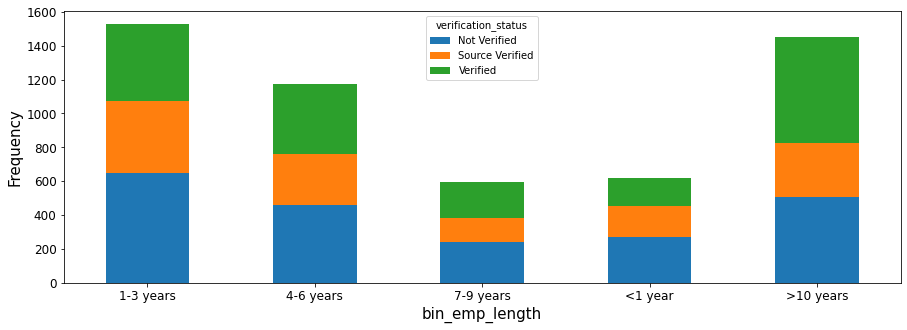

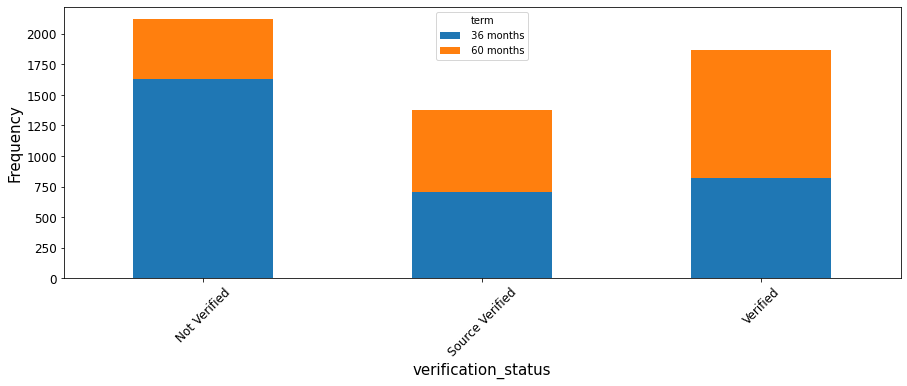

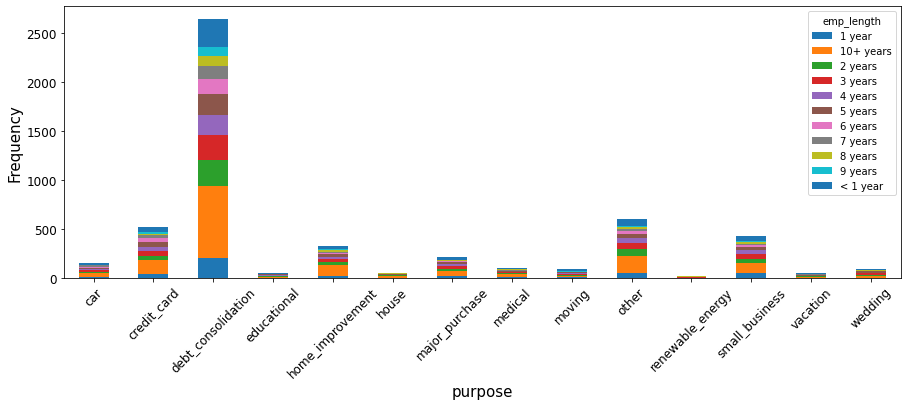

In [253]:
#Plotting relevant graphs
plot_bar_cat_bi(lc_df_co,"bin_emp_length","verification_status",0,0)
plot_bar_cat_bi(lc_df_co,"term","verification_status",45,0)
plot_bar_cat_bi(lc_df_co,"purpose","emp_length",45,1)

**Inferences**
1) For most of the charged off not verified customers the preferred loan tenure is 36 months</br>
2) For employees with experience less than equal to 1 year, most of the charged off customers have not verified documents while charged off customers with more than 10 years experience have verified documents</br>
3) Most of the charged off employees with more than 10 years of experience take loans for debt consolidation</br>

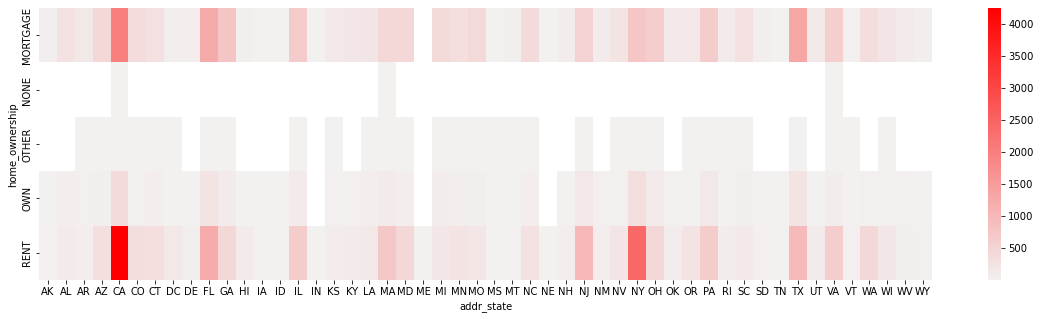

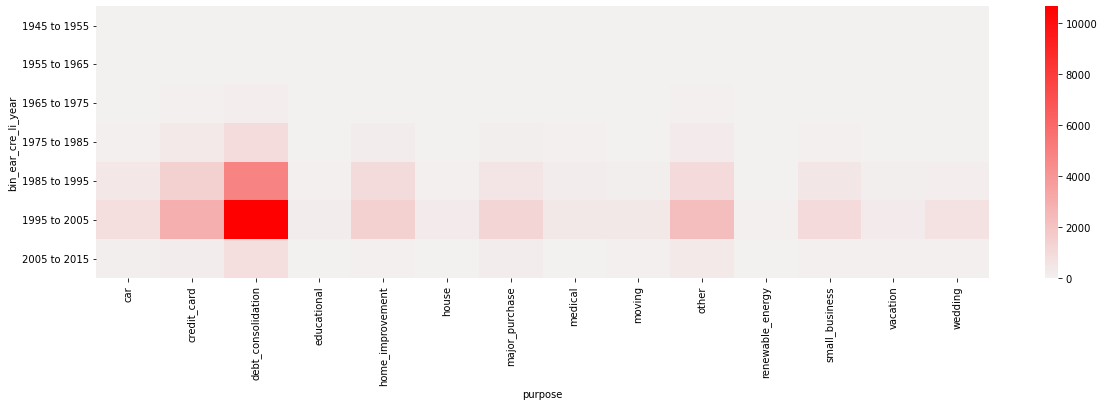

In [254]:
#Heat Maps
def heat_map(df,indexname,column):
    df["loan_status_flag"]=df["loan_status"].replace({"Charged Off":"1","Fully Paid":"0"}).astype(int)
    pivot_df=df.pivot_table(index=column,columns=indexname,values="loan_status_flag",aggfunc="count")
    pivot_df.round(0)
    redmap=sns.light_palette("red", as_cmap=True)
    plt.figure(figsize=(20,5))
    sns.heatmap(pivot_df,cmap=redmap)
heat_map(lc_df,"addr_state","home_ownership")
heat_map(lc_df,"purpose","bin_ear_cre_li_year")

Inference
State vs Home Ownership :
It is observed the customers living on rent in California are charging off more. 
This might be probably due to high rental amounts in California

Earliest Credit Line vs Purpose:
The customers who have earliest credit lines starting from the year 1985 to 2005 and taking loans for debt consolidation are charging off more
This might be probably to repay the earlier loans taken 


# **Conclusion:**
 The major factors for charging off loans :
 1) Loan amount – For amounts greater than 10000
 2) Annual income - For income less than 50000
 3) Interest rate - For interest rates greater than 10%
 4) Debt to Income Ratio – For dti greater than 15
 5) Term – For loan tenure of 60 months
 6) Employee Length – For employees with more than 10 years of experience
 7) Purpose – Debt consolidation and small business
 8) Earliest Credit Line – For customers starting credit lines from 1985 to 2005
 9) Address State – Customers from California and Florida

**“It is recommended for the lending club to be more cautious in providing loans to customers who fall under any of the above criteria”**
